In [1]:
from PW_explorer.load_worlds import load_worlds
from PW_explorer.run_clingo import run_clingo
from PW_explorer.visualize import PWEVisualization
from PW_explorer.helper import pw_slicer, rel_slicer, rel_name_remapper
from PW_explorer.export import PWEExport

In [2]:
import networkx as nx
from nxpd import draw
import nxpd
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

In [3]:
%load_ext PWE_NB_Extension

In [4]:
from IPython.display import HTML as html_print

def cstr(s, color='black'):
    return "<text style=color:{}>{}</text>".format(color, s)

In [5]:
def rule_to_node(atom, occ):
    return "{}[{}]".format(atom.strip('"'), occ)

def head_to_node(head):
    return head.strip('"')

def print_colored_query_string(pw_rel_dfs):
    
    heads = {h: {} for h in set(pw_rel_dfs['ruleH_1']['HEAD'])}
    rules = {}
    for _, p in pw_rel_dfs['ruleOcc_2'][['ATOM', 'OCC']].iterrows():
        rules[(p['ATOM'], int(p['OCC']))] = {}
    
    true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
    true_rules = set([])
    for _, p in pw_rel_dfs['ruleOccTrue_2'][['ATOM', 'OCC']].iterrows():
        true_rules.add((p['ATOM'], int(p['OCC'])))
    
    for _, row in pw_rel_dfs['newHArc_3'].iterrows():
        pos = int(row['POS'])
        h = row['HEAD']
        var = row['VAR']
        heads[h][pos] = var
    for _, row in pw_rel_dfs['newArc_4'].iterrows():
        rule = (row['ATOM'], int(row['OCC']))
        pos = int(row['POS'])
        var = row['VAR']
        rules[rule][pos] = var
        
#     print(heads, rules, true_heads, true_rules)
    
    heads_htmls = []
    for h in sorted(heads.keys()):
        variables = [heads[h][k] for k in sorted(heads[h].keys())]
        heads_htmls.append(cstr('{}({})'.format(head_to_node(h), ','.join(variables)), 'green' if h in true_heads else 'red'))
    
    
    rules_htmls = []
    for (r, occ) in sorted(rules.keys()):
        variables = [rules[(r,occ)][k] for k in sorted(rules[(r,occ)].keys())]
        rules_htmls.append(cstr('{}({})'.format(head_to_node(r), ','.join(variables)), 'green' if (r,occ) in true_rules else 'red'))
    
#     display(html_print(cstr(' '.join(heads_htmls + rules_htmls))))
    
    
    heads_htmls_combined = cstr(' ; '.join(heads_htmls))
    rules_htmls_combined = cstr(', '.join(rules_htmls))
    display(html_print(cstr('{} :- {}.'.format(heads_htmls_combined, rules_htmls_combined))))
    
    eqls = []
    for _, row in pw_rel_dfs['eqOrd_3'].iterrows():
        eqls.append('{} = {}'.format(row['VAR1'], row['VAR2']))
    print('where' if len(eqls) > 0 else '')
    print(' and '.join(eqls))
    
    
def get_pattern_graph(pw_rel_dfs):
    g = nx.MultiDiGraph()
    true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
    if len(true_heads) > 0:
        print("Success Pattern:")
    else:
        print("Failure Pattern:")
    
    if 'e_3' in pw_rel_dfs:
        for _, row in pw_rel_dfs['e_3'].iterrows():
            g.add_edge(row['NODE1'], row['NODE2'], color='darkgreen', label='{}{}'.format('e', row['OCC']))
    if 'ne_3' in pw_rel_dfs:
        for _, row in pw_rel_dfs['ne_3'].iterrows():
            g.add_edge(row['NODE1'], row['NODE2'], color='red', style='dotted', label='{}{}'.format('e', row['OCC']))
    
    return g

def get_pattern_graph2(pw_rel_dfs, no_node_labels=False):
    g = nx.DiGraph()
    true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
    if len(true_heads) > 0:
        print("Success Pattern:")
    else:
        print("Failure Pattern:")
    
    if 'e_3' in pw_rel_dfs:
        for _, row in pw_rel_dfs['e_3'].iterrows():
            if (row['NODE1'], row['NODE2']) in g.edges:
                g.edges[(row['NODE1'], row['NODE2'])]['label'] += ';{}{}'.format('e', row['OCC'])
            else:
                g.add_edge(row['NODE1'], row['NODE2'], color='darkgreen', label='{}{}'.format('e', row['OCC']))
    if 'ne_3' in pw_rel_dfs:
        for _, row in pw_rel_dfs['ne_3'].iterrows():
            if (row['NODE1'], row['NODE2']) in g.edges:
                g.edges[(row['NODE1'], row['NODE2'])]['label'] += ';{}{}'.format('e', row['OCC'])
            else:
                g.add_edge(row['NODE1'], row['NODE2'], color='red', style='dotted', label='{}{}'.format('e', row['OCC']))
    
    if no_node_labels:
        for n in g.nodes:
            g.nodes[n]['label'] = '  '
    
    return g

def get_incidence_graph(pw_rel_dfs):
    
    g = nx.MultiDiGraph()
    g.graph['rankdir'] = 'LR'
    
    for _, row in pw_rel_dfs['ruleH_1'].iterrows():
        g.add_node(head_to_node(row['HEAD']), rank='min', color='red', shape='box', style='filled')
    for _, row in pw_rel_dfs['ruleHTrue_1'].iterrows():
        g.add_node(head_to_node(row['HEAD']), rank='min', color='green', style='filled')
    for _, row in pw_rel_dfs['ruleOcc_2'].iterrows():
        g.add_node(rule_to_node(row['ATOM'], row['OCC']), color='red', style='filled')
    for _, row in pw_rel_dfs['ruleOccTrue_2'].iterrows():
        g.add_node(rule_to_node(row['ATOM'], row['OCC']), color='green', style='filled')
    
    
    for _, row in pw_rel_dfs['newHArc_3'].iterrows():
        g.add_edge(row['VAR'], head_to_node(row['HEAD']), label=row['POS'])
    for _, row in pw_rel_dfs['newArc_4'].iterrows():
        g.add_edge(row['VAR'], rule_to_node(row['ATOM'], row['OCC']), label=row['POS'])
    
    for _, row in pw_rel_dfs['eqOrd_3'].iterrows():
        g.add_edge(row['VAR2'], row['VAR1'], constraint='false', color='green', style='dotted')
    
    return g

In [94]:
def eq_groups(pw_rel_dfs, single_grps=False):
    
    p = pw_rel_dfs['eqOrdMinimal_3'].groupby(['VAR1'])
    new_vars = set(pw_rel_dfs['newVar_2']['VAR'])
    groups = []
    for var1, group in p.groups.items():
        new_vars.remove(var1)
        groups.append([var1]+[pw_rel_dfs['eqOrdMinimal_3'].loc[i]['VAR2'] for i in group])
    if single_grps:
        for v in new_vars:
            groups.append([v])
    return groups
    

def chain_eqs_rules(pw_rel_dfs):
    
    eqls = []
    groups = eq_groups(pw_rel_dfs)
    for group in groups:
        eqls.append('='.join(group))
    
    return eqls

def eq_rules(pw_rel_dfs):
    
    eqls = []
    groups = eq_groups(pw_rel_dfs)
    
    for group in groups:
        var1 = group[0]
        for var2 in group[1:]:
            eqls.append('{}={}'.format(var1, var2))
    
    return eqls

def neq_rules(pw_rel_dfs):
    neqls = []
    for _, row in pw_rel_dfs['neqOrd_3'].iterrows():
        neq_str = '{} != {}'.format(row['VAR1'], row['VAR2'])
        neqls.append(cstr(neq_str))
    return neqls

def get_query_heads(ruleH_dfs, ruleHTrue_dfs, hArc_df, colored=True):
    
    heads = {h: {} for h in set(ruleH_dfs['HEAD'])}
    true_heads = set(ruleHTrue_dfs['HEAD'])
    for _, row in hArc_df.iterrows():
        pos = int(row['POS'])
        h = row['HEAD']
        var = row['VAR']
        heads[h][pos] = var
    heads_htmls = []
    for h in sorted(heads.keys()):
        variables = [heads[h][k] for k in sorted(heads[h].keys())]
        is_true = h in true_heads
        h_str = '{}{}({})'.format('' if is_true else 'n', head_to_node(h), ','.join(variables))
        if colored:
            heads_htmls.append(cstr(h_str, 'green' if is_true else 'red'))
        else:
            heads_htmls.append(cstr(h_str))
    return heads_htmls

def get_original_query_heads(pw_rel_dfs, colored=True):
    
    return get_query_heads(pw_rel_dfs['ruleH_1'], pw_rel_dfs['ruleHTrue_1'], pw_rel_dfs['hArc_3'], colored)

def get_substituted_query_heads(pw_rel_dfs, colored=True):
    
    return get_query_heads(pw_rel_dfs['ruleH_1'], pw_rel_dfs['ruleHTrue_1'], pw_rel_dfs['newHArc_3'], colored)

def get_query_body_rules(ruleOcc_df, ruleOccTrue_df, arc_df, colored=True):
    
    rules = {}
    for _, p in ruleOcc_df[['ATOM', 'OCC']].iterrows():
        rules[(p['ATOM'], int(p['OCC']))] = {}
    
    true_rules = set([])
    for _, p in ruleOccTrue_df[['ATOM', 'OCC']].iterrows():
        true_rules.add((p['ATOM'], int(p['OCC'])))
    
    for _, row in arc_df.iterrows():
        rule = (row['ATOM'], int(row['OCC']))
        pos = int(row['POS'])
        var = row['VAR']
        rules[rule][pos] = var
    
    rules_htmls = []
    for (r, occ) in sorted(rules.keys()):
        variables = [rules[(r,occ)][k] for k in sorted(rules[(r,occ)].keys())]
        is_true = (r,occ) in true_rules
        r_str = '{}{}({})'.format('' if is_true else 'not ', head_to_node(r), ','.join(variables))
        if colored:
            rules_htmls.append(cstr(r_str, 'green' if is_true else 'red'))
        else:
            rules_htmls.append(cstr(r_str))
    
    return rules_htmls

def get_original_query_body_rules(pw_rel_dfs, colored=True):
    
    return get_query_body_rules(pw_rel_dfs['ruleOcc_2'], pw_rel_dfs['ruleOccTrue_2'], pw_rel_dfs['arc_4'], colored)

def get_substituted_query_body_rules(pw_rel_dfs, colored=True):
    
    return get_query_body_rules(pw_rel_dfs['ruleOcc_2'], pw_rel_dfs['ruleOccTrue_2'], pw_rel_dfs['newArc_4'], colored)
    
def print_rewritten_query_string(pw_rel_dfs):

    heads_htmls = get_substituted_query_heads(pw_rel_dfs, colored=True)
    rules_htmls = get_substituted_query_body_rules(pw_rel_dfs, colored=True)
    neqls = neq_rules(pw_rel_dfs)
    rules_htmls.extend(neqls)
    
    heads_htmls_combined = ' ; '.join(heads_htmls)
    rules_htmls_combined = ', '.join(rules_htmls)
    
    display(html_print(cstr('{} :- {}.'.format(heads_htmls_combined, rules_htmls_combined))))
    

def print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True):
    
    heads_htmls = get_original_query_heads(pw_rel_dfs, colored=True)
    rules_htmls = get_original_query_body_rules(pw_rel_dfs, colored=True)
    eqls = chain_eqs_rules(pw_rel_dfs) if chain_eq else eq_rules(pw_rel_dfs)
    neqls = neq_rules(pw_rel_dfs)
    rules_htmls.extend(eqls)
    rules_htmls.extend(neqls)
    
    heads_htmls_combined = ' ; '.join(heads_htmls)
    rules_htmls_combined = ', '.join(rules_htmls)
    
    display(html_print(cstr('{} :- {}.'.format(heads_htmls_combined, rules_htmls_combined))))
    
def print_fancy_rewrite(pw_rel_dfs):
    
    heads_htmls = get_original_query_heads(pw_rel_dfs, colored=True)
    rules_htmls = get_original_query_body_rules(pw_rel_dfs, colored=True)
    eq_grps = eq_groups(pw_rel_dfs, single_grps=True)
    eqls = ['='.join(grp) for grp in eq_grps]
    eqls = ['[{}]'.format(eq_grp) for eq_grp in eqls]
    
    heads_htmls_combined = ' ; '.join(heads_htmls)
    rules_htmls_combined = ', '.join(rules_htmls)
    eqls_combined = cstr(''.join(eqls), 'blue')
    
    display(html_print(cstr('{} :- {}. % {}'.format(heads_htmls_combined, rules_htmls_combined, eqls_combined))))

In [85]:
%%clingo --donot-run --donot-display_input

tri(X,Y,Z) :- e(X,Y), e(Y,Z), e(Z,X).

In [86]:
%%clingo --donot-display_input -exp query_analysis

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z", node).

% schema ruleOcc(ATOM, OCC).
ruleOcc("e", 1..3).

% schema ruleH(HEAD)
ruleH("tri").

% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) ; not ruleOccTrue(R, OC) :- ruleOcc(R, OC).

% schema ruleHTrue(HEAD)
ruleHFalse(H) :- ruleH(H), ruleOcc(R, OCC), not ruleOccTrue(R,OCC).
ruleHTrue(H)  :- ruleH(H), not ruleHFalse(H).

% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.


% schema arc(VAR, POS, ATOM, OCC)
arc("X", 1, "e", 1).
arc("Y", 2, "e", 1).
arc("Y", 1, "e", 2).
arc("Z", 2, "e", 2).
arc("Z", 1, "e", 3).
arc("X", 2, "e", 3).

% schema hArc(VAR, POS, HEAD)
hArc("X", 1, "tri") :- ruleH("tri").
hArc("Y", 2, "tri") :- ruleH("tri").
hArc("Z", 3, "tri") :- ruleH("tri").



% schema newVar(VAR, DOMAIN)
newVar(VAR, TYPE) :- var(VAR, TYPE), not eqOrd(_,VAR,TYPE).
% schema eqOrdMinimal(VAR1, VAR2, DOMAIN)
eqOrdMinimal(A,B,TYPE) :- eqOrd(A,B,TYPE), newVar(A,TYPE).
% schema neqOrd(VAR1, VAR2, DOMAIN)
neqOrd(A,B,TYPE) :- newVar(A,TYPE), newVar(B,TYPE), A<B.

% Find the new arcs, getting rid of the redundancies

% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

% It cannot be true that eX and eY have the same variable assignments but one is True while other is False
:- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), ruleOccTrue("e", OCC1), not ruleOccTrue("e", OCC2). 

% eqAtomOccOrd("e", OCC1, OCC2) :- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), OCC1<OCC2.
% eqAtomOccOrd("e", OCC1, OCC3) :- eqAtomOccOrd("e", OCC1, OCC2), eqAtomOccOrd("e", OCC2, OCC3).

% fAtom("e", V1, V2) :- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), not eqAtomOccOrd("e",_,OCC1).


% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% schema e(OCC, NODE1, NODE2)
e(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% New inferred missing edges
% schema ne(NODE1, NODE2)
ne(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).

% schema ne(OCC, NODE1, NODE2)
ne(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).



% Given these inferred edges, can a triangle exist?
% tri(V1,V2,V3) :- e(V1,V2), e(V2,V3), e(V3,V1).
% triExists :- tri(_,_,_).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

% :- not ruleHTrue("tri").


#show ruleOccTrue/2.
#show var/2.
#show newVar/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show neqOrd/3.
#show eqOrdMinimal/3.
#show arc/4.
#show newArc/4.
#show hArc/3.
#show newHArc/3.
#show e/2.
#show ne/2.
#show e/3.
#show ne/3.
#show eqAtomOccOrd/3.
#show fAtom/3.
% #show triExists/0.
% #show tri/3.
#show ruleHTrue/1.







Output:


'Answer: 1\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z",2,"e",2) newArc("Z",1,"e",3) ne(1,"X","Y") ne(2,"Y","Z") ne(3,"Z","X") ne("X","Y") ne("Y","Z") ne("Z","X") newHArc("Y",2,"tri") newHArc("Z",3,"tri") newVar("Y",node) newVar("Z",node) neqOrd("X","Y",node) neqOrd("X","Z",node) neqOrd("Y","Z",node)\nAnswer: 2\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z",2,"e",2) newArc("Z",1,"e",3) ruleOccTrue("e",1) ne(2,"Y","Z") ne(3,"Z","X") ne("Y","Z") ne("Z","X") e(1,"X","Y") e("X","Y") newHArc("Y",2,"tri") newHArc("Z",3,"tri") newVar("Y",node) newVar("Z",node) neqOrd("X","Y",node) neqOrd("X","Z",node) neqOrd("Y","Z",node)\nAnswer: 3\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z",2,"e",2) newArc("Z",1,"e",3) ruleOccTrue("e",3) ne(1,"X","Y") ne(2,"Y","Z") ne("X","Y") ne("Y","Z") e(3,"Z","X") e("Z","X") newHArc("Y",2,"tri") newHArc("Z",3,"tri") newVar("Y",node) newVar("Z",node) neqOrd("X","Y",node) neqOrd("X","Z",node) neqOrd("Y","Z",node)\nAnswer: 4\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z",2,"e",2) newArc("Z",1,"e",3) ruleOccTrue("e",1) ruleOccTrue("e",3) ne(2,"Y","Z") ne("Y","Z") e(1,"X","Y") e(3,"Z","X") e("X","Y") e("Z","X") newHArc("Y",2,"tri") newHArc("Z",3,"tri") newVar("Y",node) newVar("Z",node) neqOrd("X","Y",node) neqOrd("X","Z",node) neqOrd("Y","Z",node)\nAnswer: 5\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) eqOrd("Y","Z",node) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) ne(2,"Y","Y") ne(1,"X","Y") ne(3,"Y","X") ne("Y","X") ne("X","Y") ne("Y","Y") newHArc("Y",2,"tri") newHArc("Y",3,"tri") newVar("Y",node) neqOrd("X","Y",node) eqOrdMinimal("Y","Z",node)\nAnswer: 6\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z",node) hArc("X",1,"tri") hArc("Y",2,"tri") hArc("Z",3,"tri") newHArc("X",1,"tri") arc("X",1,"e",1) arc("Y",2,"e",1) arc("Y",1,"e",2) arc("Z",2,"e",2) arc("Z",1,"e",3) arc("X",2,"e",3) newArc("X",1,"e",1) newArc("X",2,"e",3) eqOrd("Y","Z",node) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Y",2,"e",1) newArc("Y",1,"e",2) ruleOccTrue("e",1) ne(2,"Y","Y") ne(3,"Y","X") ne("Y","X") ne("Y","Y") e(1,"X","Y") e("X","Y") newHArc("Y",2,"tri") newHArc("Y",3,"tri") newVar("Y",node) neqOrd("X","Y",node) eqOrdMinimal("Y","Z",node)\nAnswer: 7\nruleH("tri") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("

In [64]:
%%clingo --donot-run --donot-display_input

thop(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y).

In [91]:
%%clingo --donot-display_input -exp query_analysis

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z1", node).
var("Z2", node).

% schema ruleOcc(ATOM, OCC).
ruleOcc("e", 1..3).

% schema ruleH(HEAD)
ruleH("thop").

% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) ; not ruleOccTrue(R, OC) :- ruleOcc(R, OC).

% schema ruleHTrue(HEAD)
ruleHFalse(H) :- ruleH(H), ruleOcc(R, OCC), not ruleOccTrue(R,OCC).
ruleHTrue(H)  :- ruleH(H), not ruleHFalse(H).

% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.

% schema newVar(VAR, DOMAIN)
newVar(VAR, TYPE) :- var(VAR, TYPE), not eqOrd(_,VAR,TYPE).

% schema eqOrdMinimal(VAR1, VAR2, DOMAIN)
eqOrdMinimal(A,B,TYPE) :- eqOrd(A,B,TYPE), newVar(A,TYPE).

% schema neqOrd(VAR1, VAR2, DOMAIN)
neqOrd(A,B,TYPE) :- newVar(A,TYPE), newVar(B,TYPE), A<B.

% schema arc(VAR, POS, ATOM, OCC)
arc("X",  1, "e", 1).
arc("Z1", 2, "e", 1).
arc("Z1", 1, "e", 2).
arc("Z2", 2, "e", 2).
arc("Z2", 1, "e", 3).
arc("Y",  2, "e", 3).

% schema hArc(VAR, POS, HEAD)
hArc("X", 1, "thop") :- ruleH("thop").
hArc("Y", 2, "thop") :- ruleH("thop").

% Find the new arcs, getting rid of the redundancies

% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

% It cannot be true that eX and eY have the same variable assignments but one is True while other is False
:- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), ruleOccTrue("e", OCC1), not ruleOccTrue("e", OCC2). 


% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% schema e(OCC, NODE1, NODE2)
e(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% New inferred missing edges
% schema ne(NODE1, NODE2)
ne(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).

% schema ne(OCC, NODE1, NODE2)
ne(OCC,V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).



% Given these inferred edges, can a triangle exist?
% tri(V1,V2,V3) :- e(V1,V2), e(V2,V3), e(V3,V1).
% triExists :- tri(_,_,_).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

:- not ruleHTrue("thop").


#show ruleOccTrue/2.
#show var/2.
#show newVar/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show neqOrd/3.
#show eqOrdMinimal/3.
#show arc/4.
#show newArc/4.
#show hArc/3.
#show newHArc/3.
#show e/2.
#show ne/2.
#show e/3.
#show ne/3.
#show eqAtomOccOrd/3.
#show fAtom/3.
% #show triExists/0.
% #show tri/3.
#show ruleHTrue/1.








Output:


'Answer: 1\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Z2",2,"e",2) newArc("Z2",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Z2") e(3,"Z2","Y") e("X","Z1") e("Z1","Z2") e("Z2","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) newVar("Z2",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) neqOrd("X","Z2",node) neqOrd("Y","Z2",node) neqOrd("Z1","Z2",node)\nAnswer: 2\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z2",node) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Y") e(3,"Y","Y") e("X","Z1") e("Y","Y") e("Z1","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) eqOrdMinimal("Y","Z2",node)\nAnswer: 3\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z1",node) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Z2",2,"e",2) newArc("Z2",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Y") e(2,"Y","Z2") e(3,"Z2","Y") e("X","Y") e("Y","Z2") e("Z2","Y") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z2",node) neqOrd("X","Y",node) neqOrd("X","Z2",node) neqOrd("Y","Z2",node) eqOrdMinimal("Y","Z1",node)\nAnswer: 4\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Z1","Z2",node) newArc("Z1",2,"e",2) newArc("Z1",1,"e",3) newArc("Z1",2,"e",1) newArc("Z1",1,"e",2) newArc("Y",2,"e",3) e(1,"X","Z1") e(2,"Z1","Z1") e(3,"Z1","Y") e("X","Z1") e("Z1","Y") e("Z1","Z1") newHArc("Y",2,"thop") newVar("Y",node) newVar("Z1",node) neqOrd("X","Y",node) neqOrd("X","Z1",node) neqOrd("Y","Z1",node) eqOrdMinimal("Z1","Z2",node)\nAnswer: 5\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"thop") newHArc("X",1,"thop") arc("X",1,"e",1) arc("Z1",2,"e",1) arc("Z1",1,"e",2) arc("Z2",2,"e",2) arc("Z2",1,"e",3) arc("Y",2,"e",3) newArc("X",1,"e",1) ruleOccTrue("e",1) ruleOccTrue("e",2) ruleOccTrue("e",3) ruleHTrue("thop") eqOrd("Y","Z1",node) eqOrd("Y","Z2",node) eqOrd("Z1","Z2",node) newArc("Y",2,"e",1) newArc("Y",1,"e",2) newArc("Y",2,"e",2) newArc("Y",1,"e",3) newArc("Y",2,"e",3) e(1,"X","Y") e(2,"Y","Y") e(3,"Y","Y") e("X","Y") e("Y","Y") newHArc("Y",2,"thop") newVar("Y",node) neqOrd("X","Y",node) eqOrdMinimal("Y","Z1",node) eqOrdMinimal("Y","Z2",node)\nAnswer: 6\nruleH("thop") newVar("X",node) ruleOcc("e",1) ruleOcc("e",2) ruleOcc("e",3) var("X",node) var("Y",node) var("Z1",node) var("Z2",node) hArc("X",1,"thop") hArc("Y",2,"t

In [92]:
query_analysis['pw_rel_dfs'], query_analysis['rel_schema'], query_analysis['pw_objs'] =load_worlds(query_analysis['asp_soln'],
                                                                                                   query_analysis['meta_data'])


Number of Models: 15


In [95]:
for i in range(1, len(query_analysis['pw_objs'])+1):
    print("\nPW:", i)
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]        

#     g = get_incidence_graph(pw_rel_dfs)
#     display(draw(g))
    

#     print_colored_query_string(pw_rel_dfs)
    print_rewritten_query_string(pw_rel_dfs)
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=False)
    print_explicit_rewritten_query_string(pw_rel_dfs, chain_eq=True)
    print_fancy_rewrite(pw_rel_dfs)
    
#     g = get_pattern_graph2(pw_rel_dfs)
#     draw(g, format='pdf', filename='{}.{}'.format('3hop_all_patterns/pw_{}'.format(i), 'pdf'), show='none')
#     display(draw(g))


PW: 1



PW: 2



PW: 3



PW: 4



PW: 5



PW: 6



PW: 7



PW: 8



PW: 9



PW: 10



PW: 11



PW: 12



PW: 13



PW: 14



PW: 15


In [13]:
%%clingo --donot-display_input -lci qep_eq_check --donot-run

% e(X,Y) :- e(Y,X). --> only if undirected
gnode1(X) :- e1(X,_).
gnode1(X) :- e1(_,X).
gnode1(X) :- ne1(X,_).
gnode1(X) :- ne1(_,X).

gnode2(X) :- e2(X,_).
gnode2(X) :- e2(_,X).
gnode2(X) :- ne2(X,_).
gnode2(X) :- ne2(_,X).

vmap(X,Y) ; not vmap(X,Y) :- gnode1(X), gnode2(Y).
:- vmap(X1,Y1), vmap(X2,Y2), e1(X1,X2), not e2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not e1(X1,X2), e2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), ne1(X1,X2), not ne2(Y1,Y2).
:- vmap(X1,Y1), vmap(X2,Y2), not ne1(X1,X2), ne2(Y1,Y2).

% used1(X) :- vmap(X,_).
% :- gnode(X), not used1(X).
% :- vmap(X,Y),vmap(X,Z),Y!=Z.
% :- vmap(Y,X),vmap(Z,X),Y!=Z.

:- gnode1(X), #count {Y: vmap(X,Y)} != 1.
:- gnode2(Y), #count {X: vmap(X,Y)} != 1.

#show.
% #show vmap/2.

In [14]:
def are_equivalent_patterns(pw1, pw2, eq_check_encoding=qep_eq_check):
    
    def get_edge_facts(pw, edge_rel_idx):
        pw_objs = [pw]
        _,_,pw_objs = rel_slicer(None, None, pw_objs, rels_to_use=['e_2', 'ne_2'])
        _, pw_objs, _ = rel_name_remapper(None, pw_objs, None, rel_name_map={'e_2': 'e{}_2'.format(str(edge_rel_idx)),
                                                                             'ne_2': 'ne{}_2'.format(str(edge_rel_idx))})
        return PWEExport.export_as_asp_facts(pw_objs, include_pw_ids=False)
    
    pw1_edge_facts = get_edge_facts(pw1, 1)
    pw2_edge_facts = get_edge_facts(pw2, 2)
    # print(pw1_edge_facts, pw2_edge_facts)
    asp_out, _ = run_clingo(eq_check_encoding.split('\n')+pw1_edge_facts+pw2_edge_facts, num_solutions=1)
    # print(asp_out)
    _,_,eq_check_pws = load_worlds(asp_out, silent=True)
    
    return len(eq_check_pws) >= 1

In [15]:
are_equivalent_patterns(query_analysis['pw_objs'][5], query_analysis['pw_objs'][6])

False

In [16]:
def get_equivalent_sets(objs, match_func):
    
    sets = []
    curr_iter_set = list(range(len(objs)))
    while len(curr_iter_set) > 0:
        next_iter_set = []
        seed = curr_iter_set[0]
        curr_set = {objs[seed]}
        for c in curr_iter_set[1:]:
            if match_func(objs[seed], objs[c]):
                curr_set.add(objs[c])
            else:
                next_iter_set.append(c)
        sets.append(curr_set)
        curr_iter_set = next_iter_set
    return sets

In [17]:
sets = get_equivalent_sets(query_analysis['pw_objs'], are_equivalent_patterns)

In [18]:
for s in sets:
    print({pw.pw_id for pw in s})

{1}
{2}
{3}
{4}
{5}
{6}
{7}
{8}
{9}
{10}
{11}
{12, 13, 14}
{15}


In [19]:
len(sets)

13




Set: 1

PW: 1


Success Pattern:


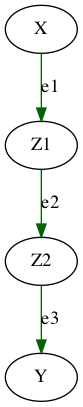




Set: 2

PW: 2


Success Pattern:


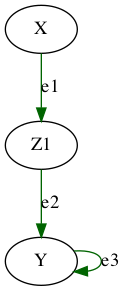




Set: 3

PW: 3


Success Pattern:


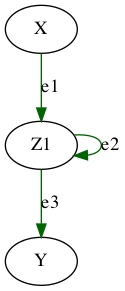




Set: 4

PW: 4


Success Pattern:


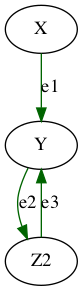




Set: 5

PW: 5


Success Pattern:


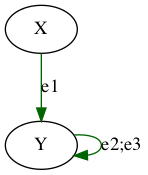




Set: 6

PW: 6


Success Pattern:


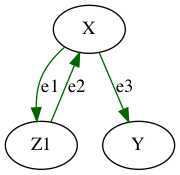




Set: 7

PW: 7


Success Pattern:


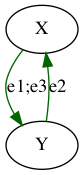




Set: 8

PW: 8


Success Pattern:


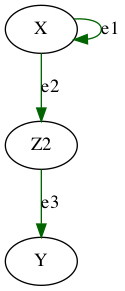




Set: 9

PW: 9


Success Pattern:


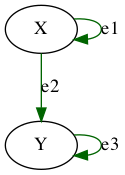




Set: 10

PW: 10


Success Pattern:


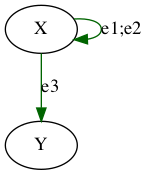




Set: 11

PW: 11


Success Pattern:


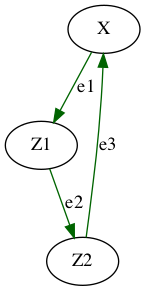




Set: 12

PW: 13


Success Pattern:


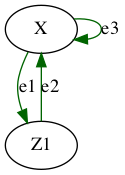




Set: 13

PW: 15


Success Pattern:


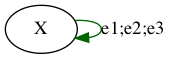

In [20]:
for i, s in enumerate(sets):
    print("\n\n\nSet:", i+1)
    for j, pw in enumerate(s):
        print("\nPW:", pw.pw_id)
        pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw.pw_id])[0]
#         print_colored_query_string(pw_rel_dfs)
        print_rewritten_query_string(pw_rel_dfs)
        g = get_pattern_graph2(pw_rel_dfs, no_node_labels=False)
#         draw(g, format='pdf', filename='{}.{}'.format('tri_eq_patterns/set_{}'.format(i+1), 'pdf'), show='none')
        display(draw(g))
        break

Set: 1 (1)


Success Pattern:


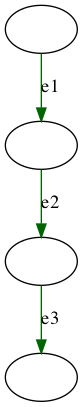

Set: 2 (1)


Success Pattern:


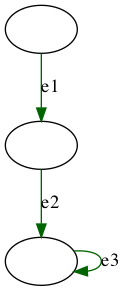

Set: 3 (1)


Success Pattern:


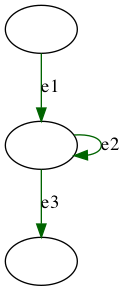

Set: 4 (1)


Success Pattern:


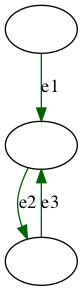

Set: 5 (1)


Success Pattern:


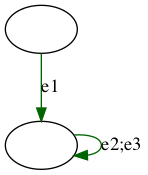

Set: 6 (1)


Success Pattern:


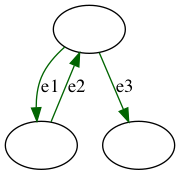

Set: 7 (1)


Success Pattern:


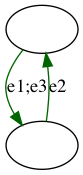

Set: 8 (1)


Success Pattern:


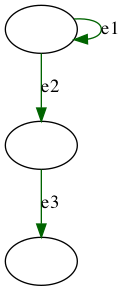

Set: 9 (1)


Success Pattern:


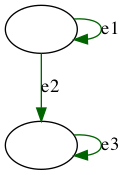

Set: 10 (1)


Success Pattern:


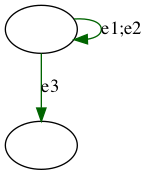

Set: 11 (1)


Success Pattern:


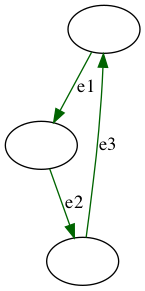

Set: 12 (3)


Success Pattern:


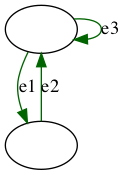

Success Pattern:


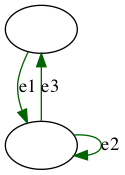

Success Pattern:


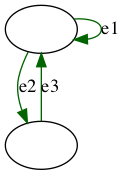

Set: 13 (1)


Success Pattern:


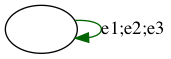

13

In [21]:
num_success_patterns = 0
for i,s in enumerate(sets):
    s = list(s)
    eg = s[0]
    pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [eg.pw_id])[0]
    true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
    if len(true_heads) > 0:
        num_success_patterns += 1
        print("Set:", num_success_patterns, '({})'.format(len(s)))
    
        for j, pw in enumerate(s):
            pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [pw.pw_id])[0]
            true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
            print_rewritten_query_string(pw_rel_dfs)
            g = get_pattern_graph2(pw_rel_dfs, no_node_labels=True)
#             draw(g, format='pdf', filename='{}.{}'.format('3hop_eq_success_patterns/set_{}'.format(num_success_patterns), 'pdf'), show='none')
            display(draw(g))
num_success_patterns

In [50]:
num_success_patterns

13

In [45]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop1(X,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y), X != Y, X != Z1, Y != Z1, X != Z2, Y != Z2, Z1 != Z2.
thop2(X,Y) :- e(X,Y), e(Y,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop3(X,Y) :- e(X,Z1), e(Z1,Y), e(Y,Y), X != Y, X != Z1, Y != Z1.
thop4(X,Y) :- e(X,Z1), e(Z1,Z1), e(Z1,Y), X != Y, X != Z1, Y != Z1.
thop5(X,Y) :- e(X,Y), e(Y,Y), e(Y,Y), X != Y.
thop6(X,Y) :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop7(X,Y) :- e(X,X), e(X,Y), e(Y,Y), X != Y.
thop8(X,Y) :- e(X,Z1), e(Z1,X), e(X,Y), X != Y, X != Z1, Y != Z1.
thop9(X,Y) :- e(X,Y), e(Y,X), e(X,Y), X != Y.
thop10(X,Y) :- e(X,X), e(X,X), e(X,Y), X != Y.
thop11(X,X) :- e(X,Z1), e(Z1,Z2), e(Z2,X), X != Z1, X != Z2, Z1 != Z2.
thop12(X,X) :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop13(X,X) :- e(X,X), e(X,X), e(X,X).

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop5(b,a) thop6(a,c) thop8(b,c) thop9(a,b) thop9(b,a) thop10(a,b) thop12(a,a) thop13(a,a)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [46]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop1(X,Z1,Z2,Y) :- e(X,Z1), e(Z1,Z2), e(Z2,Y), X != Y, X != Z1, Y != Z1, X != Z2, Y != Z2, Z1 != Z2.
thop2(X,Y,Z2,Y) :- e(X,Y), e(Y,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop3(X,Z1,Y,Y) :- e(X,Z1), e(Z1,Y), e(Y,Y), X != Y, X != Z1, Y != Z1.
thop4(X,Z1,Z1,Y) :- e(X,Z1), e(Z1,Z1), e(Z1,Y), X != Y, X != Z1, Y != Z1.
thop5(X,Y,Y,Y) :- e(X,Y), e(Y,Y), e(Y,Y), X != Y.
thop6(X,X,Z2,Y) :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop7(X,X,Y,Y) :- e(X,X), e(X,Y), e(Y,Y), X != Y.
thop8(X,Z1,X,Y) :- e(X,Z1), e(Z1,X), e(X,Y), X != Y, X != Z1, Y != Z1.
thop9(X,Y,X,Y) :- e(X,Y), e(Y,X), e(X,Y), X != Y.
thop10(X,X,X,Y) :- e(X,X), e(X,X), e(X,Y), X != Y.
thop11(X,Z1,Z2,X) :- e(X,Z1), e(Z1,Z2), e(Z2,X), X != Z1, X != Z2, Z1 != Z2.
thop12(X,X,Z2,X) :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop13(X,X,X,X) :- e(X,X), e(X,X), e(X,X).

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop5(b,a,a,a) thop6(a,a,b,c) thop8(b,a,b,c) thop9(a,b,a,b) thop9(b,a,b,a) thop10(a,a,a,b) thop12(a,a,b,a) thop13(a,a,a,a)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.002s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.002s'

In [56]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop1 :- e(X,Z1), e(Z1,Z2), e(Z2,Y), X != Y, X != Z1, Y != Z1, X != Z2, Y != Z2, Z1 != Z2.
thop2 :- e(X,Y), e(Y,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop3 :- e(X,Z1), e(Z1,Y), e(Y,Y), X != Y, X != Z1, Y != Z1.
thop4 :- e(X,Z1), e(Z1,Z1), e(Z1,Y), X != Y, X != Z1, Y != Z1.
thop5 :- e(X,Y), e(Y,Y), e(Y,Y), X != Y.
thop6 :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.
thop7 :- e(X,X), e(X,Y), e(Y,Y), X != Y.
thop8 :- e(X,Z1), e(Z1,X), e(X,Y), X != Y, X != Z1, Y != Z1.
thop9 :- e(X,Y), e(Y,X), e(X,Y), X != Y.
thop10 :- e(X,X), e(X,X), e(X,Y), X != Y.
thop11 :- e(X,Z1), e(Z1,Z2), e(Z2,X), X != Z1, X != Z2, Z1 != Z2.
thop12 :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop13 :- e(X,X), e(X,X), e(X,X).

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop5 thop6 thop8 thop9 thop10 thop12 thop13\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.003s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.003s'

In [47]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

e(a,d).
e(d,c).

thop6(X,Y) :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) e(a,d) e(d,c) thop6(a,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [48]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

e(a,d).
e(d,c).

thop6(X,X,Z2,Y) :- e(X,X), e(X,Z2), e(Z2,Y), X != Y, X != Z2, Y != Z2.

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) e(a,d) e(d,c) thop6(a,a,b,c) thop6(a,a,d,c)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [52]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop12_1(X,X) :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop12_2(X,X) :- e(X,Z1), e(Z1,X), e(X,X), X != Z1.
thop12_3(X,X) :- e(X,Z1), e(Z1,Z1), e(Z1,X), X != Z1.

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop12_1(a,a) thop12_2(a,a) thop12_3(b,b)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [54]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop12_1(X,X,Z2,X) :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop12_2(X,Z1,X,X) :- e(X,Z1), e(Z1,X), e(X,X), X != Z1.
thop12_3(X,Z1,Z1,X) :- e(X,Z1), e(Z1,Z1), e(Z1,X), X != Z1.

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop12_1(a,a,b,a) thop12_2(a,b,a,a) thop12_3(b,a,a,b)\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [55]:
%%clingo --donot-display_input

e(a,a).
e(a,b).
e(b,a).
e(b,c).

thop12_1 :- e(X,X), e(X,Z2), e(Z2,X), X != Z2.
thop12_2 :- e(X,Z1), e(Z1,X), e(X,X), X != Z1.
thop12_3 :- e(X,Z1), e(Z1,Z1), e(Z1,X), X != Z1.

Output:


'Answer: 1\ne(a,a) e(a,b) e(b,a) e(b,c) thop12_1 thop12_2 thop12_3\nSATISFIABLE\n\nModels       : 1\nCalls        : 1\nTime         : 0.001s (Solving: 0.00s 1st Model: 0.00s Unsat: 0.00s)\nCPU Time     : 0.001s'

In [ ]:
#### ROUGH --- FROM DEV #####

In [ ]:
def match(a,b):
    if (a==1 and b==3) or (a==1 and b==5) or (a==2 and b==4):
        return True
    return False

In [ ]:
sets = []

curr_iter_list = [1,2,3,4,5,6]
while len(curr_iter_list) > 0:
    print("curr_iter_list:", curr_iter_list)
    next_iter_list = []
    seed = curr_iter_list[0]
    print("seed:", seed)
    curr_set = {seed}
    for c in curr_iter_list[1:]:
        if match(seed, c):
            curr_set.add(c)
            print("Match", seed, c)
        else:
            next_iter_list.append(c)
    sets.append(curr_set)
    curr_iter_list = next_iter_list

sets

// Helpful: https://stackoverflow.com/questions/44274518/how-can-i-control-within-level-node-order-in-graphvizs-dot

digraph test{

rankdir = LR;
label = PW12;

// make invisible ranks
rankRuleNode [style=invisible];

rankRedundantVars [style=invis];
rankVars [style=invis];

TRI [shape=box color=red style=filled];
E1 [color=green style=filled];
E2 [color=red style=filled];
E3 [color=red style=filled];

rankRedundantVars  -> rankVars -> rankRuleNode [style=invis];

// declare nodes all out of desired order

X -> E3 [constraint = false label=1];
X -> E3 [constraint = false label=2];
X -> E1 [constraint = false label=1];
Y -> E1 [constraint = false label=2];
Y -> E2 [constraint = false label=1];
Y -> E2 [constraint = false label=2];
X -> TRI [constraint = false label=1];
X -> TRI [constraint = false label=3];
Y -> TRI [constraint = false label=2];

Z -> X [constraint=true style=dotted color=green];

{
rank = same;
// Here you enforce the desired order with "invisible" edges and arrowheads
rankVars -> X -> Y [ style=invis ];
rankdir = TB;
}

{
rank = same;
// Here you enforce the desired order with "invisible" edges and arrowheads
rankRedundantVars -> Z [ style=invis ];
rankdir = TB;
}


{
rank = same;
// Here you enforce the desired order with "invisible" edges and arrowheads
rankRuleNode -> TRI -> E1 -> E2 -> E3 [ style=invis ];
rankdir = TB;
}


}

In [ ]:
html_print(cstr(' '.join([cstr('HELLO', 'blue'), cstr('WORLD', 'red')])))

In [ ]:
%%clingo --donot-display_input -exp query_analysis

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z", node).

% schema ruleOcc(ATOM_OCC).
ruleOcc("e1"). % ruleOcc("e1", 2) instead? 2 == arity
ruleOcc("e2").
ruleOcc("e3").
ruleOcc("tri").

% schema ruleOccTrue(ATOM_OCC)
ruleOccTrue(ROC) ; not ruleOccTrue(ROC) :- ruleOcc(ROC), ROC != "tri".
ruleOccTrue("tri") :- ruleOccTrue("e1"), ruleOccTrue("e2"), ruleOccTrue("e3").

% schema eqether(VAR1, VAR2, DOMAIN) --> eq()
% should eq(A,A) be a thing?
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.

% schema arc(VAR, POSITION, ATOM_OCC)
arc("X", 1, "e1").
arc("Y", 2, "e1").
arc("Y", 1, "e2").
arc("Z", 2, "e2").
arc("Z", 1, "e3").
arc("X", 2, "e3").
arc("X", 1, "tri").
arc("Y", 2, "tri").
arc("Z", 3, "tri").

% Find the new arcs, getting rid of the redundancies
newArc(VAR, POS, ATOM_OCC) :- arc(VAR_ORIG, POS, ATOM_OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM_OCC) :- arc(VAR, POS, ATOM_OCC), not eqOrd(_,VAR,_).


% It cannot be true that e1 and e2 have the same variable assignments but one is True while other is False
:- newArc(V1, 1, "e1"), newArc(V2, 2, "e1"), newArc(V1, 1, "e2"), newArc(V2, 2, "e2"), ruleOccTrue("e1"), not ruleOccTrue("e2").
:- newArc(V1, 1, "e1"), newArc(V2, 2, "e1"), newArc(V1, 1, "e2"), newArc(V2, 2, "e2"), ruleOccTrue("e2"), not ruleOccTrue("e1").

:- newArc(V1, 1, "e2"), newArc(V2, 2, "e2"), newArc(V1, 1, "e3"), newArc(V2, 2, "e3"), ruleOccTrue("e2"), not ruleOccTrue("e3").
:- newArc(V1, 1, "e2"), newArc(V2, 2, "e2"), newArc(V1, 1, "e3"), newArc(V2, 2, "e3"), ruleOccTrue("e3"), not ruleOccTrue("e2").

:- newArc(V1, 1, "e1"), newArc(V2, 2, "e1"), newArc(V1, 1, "e3"), newArc(V2, 2, "e3"), ruleOccTrue("e1"), not ruleOccTrue("e3").
:- newArc(V1, 1, "e1"), newArc(V2, 2, "e1"), newArc(V1, 1, "e3"), newArc(V2, 2, "e3"), ruleOccTrue("e3"), not ruleOccTrue("e1").

% New inferred edges
e(V1,V2) :- newArc(V1,1,"e1"), newArc(V2,2,"e1"), ruleOccTrue("e1").
e(V1,V2) :- newArc(V1,1,"e2"), newArc(V2,2,"e2"), ruleOccTrue("e2").
e(V1,V2) :- newArc(V1,1,"e3"), newArc(V2,2,"e3"), ruleOccTrue("e3").

ne(V1,V2) :- newArc(V1,1,"e1"), newArc(V2,2,"e1"), not ruleOccTrue("e1").
ne(V1,V2) :- newArc(V1,1,"e2"), newArc(V2,2,"e2"), not ruleOccTrue("e2").
ne(V1,V2) :- newArc(V1,1,"e3"), newArc(V2,2,"e3"), not ruleOccTrue("e3").

% Given these inferred edges, can a triangle exist?
tri(V1,V2,V3) :- e(V1,V2), e(V2,V3), e(V3,V1).
triExists :- tri(_,_,_).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

% :- not ruleOccTrue("tri").

% :- triExists, not ruleOccTrue("tri"). % --> The exact assignment doesn't work, but some alignment does.


#show ruleOccTrue/1.
% #show eqOrd/3.
#show newArc/3.
#show e/2.
#show ne/2.
#show triExists/0.
#show tri/3.






In [ ]:
temp_df = query_analysis['pw_rel_dfs']['eqOrdMinimal_3']
temp_df = temp_df[temp_df['pw'] == 15]
temp_df

In [ ]:
p = temp_df.groupby(['VAR1'])

In [ ]:
p.groups

In [ ]:
for k, v in p.groups.items():
    for i in v:
        print(temp_df.loc[i]['VAR2'])

In [ ]:
# query_analysis['pw_rel_dfs'], query_analysis['rel_schema'], query_analysis['pw_objs'] = load_worlds(query_analysis['asp_soln'],
#                                                                                         query_analysis['meta_data'])




In [ ]:
# for i in range(1, len(query_analysis['pw_objs'])+1):
#     print("PW:", i)
#     pw_rel_dfs = pw_slicer(query_analysis['pw_rel_dfs'], None, [i])[0]
    
    
#     g = nx.MultiDiGraph()
#     g.graph['rankdir'] = 'LR'
    
#     g.add_node('"tri"')
    
#     for _, row in pw_rel_dfs['newArc_3'].iterrows():
#         g.add_edge(row['x1'], row['x3'], label=row['x2'])
#     for n in ['"e1"', '"e2"', '"e3"', '"tri"']:
#         g.nodes[n]['color'] = 'red'
#     for _, row in pw_rel_dfs['ruleOccTrue_1'].iterrows():
#         g.nodes[row['ATOM_OCC']]['color'] = 'green'
        
#     display(draw(g))
    
#     g = nx.MultiDiGraph()
    
    
#     if '"tri"' in list(pw_rel_dfs['ruleOccTrue_1']['ATOM_OCC']):
#         print("Success Pattern:")
#     else:
#         print("Failure Pattern:")
        
#     if len(pw_rel_dfs['triExists_0']) > 0:
#         print("Triangle Exists")
    
#     for _, row in pw_rel_dfs['e_2'].iterrows():
#         g.add_edge(row['x1'], row['x2'])
# #     for _, row in pw_rel_dfs['ne_2'].iterrows():
# #         g.add_edge(row['x1'], row['x2'], color='red', style='dotted')
    
    
#     display(draw(g))

In [ ]:
%%clingo --donot-display_input --donot-run

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z", node).

tog(A,B,TYPE) ; not tog(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
tog(A,B,TYPE) :- tog(B,A,TYPE).
tog(A,B,TYPE) :- tog(A,C,TYPE), tog(C,B,TYPE), A!=B, B!=C, A!=C.

togOrd(A,B,TYPE) :- tog(A,B,TYPE), A<B.

newVar(A, TYPE) :- var(A, TYPE), not togOrd(_,A,TYPE).


#show newVar/2.
#show togOrd/3.



In [ ]:
%%clingo --donot-display_input -exp query_analysis

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z", node).

% schema ruleOcc(ATOM, OCC).
ruleOcc("e", 1..3).

% schema ruleH(HEAD)
ruleH("tri").

% schema ruleOccTrue(ATOM, OCC)
ruleOccTrue(R, OC) ; not ruleOccTrue(R, OC) :- ruleOcc(R, OC).

% schema ruleHTrue(HEAD)
ruleHFalse(H) :- ruleH(H), ruleOcc(R, OCC), not ruleOccTrue(R,OCC).
ruleHTrue(H)  :- ruleH(H), not ruleHFalse(H).

% schema eq(VAR1, VAR2, DOMAIN)
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE), A!=B.
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE), A!=B, B!=C, A!=C.

% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<B.

% schema arc(VAR, POS, ATOM, OCC)
arc("X", 1, "e", 1).
arc("Y", 2, "e", 1).
arc("Y", 1, "e", 2).
arc("Z", 2, "e", 2).
arc("Z", 1, "e", 3).
arc("X", 2, "e", 3).

% schema hArc(VAR, POS, HEAD)
hArc("X", 1, "tri") :- ruleH("tri").
hArc("Y", 2, "tri") :- ruleH("tri").
hArc("Z", 3, "tri") :- ruleH("tri").

% Find the new arcs, getting rid of the redundancies

% schema newArc(VAR, POS, ATOM, OCC)
newArc(VAR, POS, ATOM, OCC) :- arc(VAR_ORIG, POS, ATOM, OCC), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newArc(VAR, POS, ATOM, OCC) :- arc(VAR, POS, ATOM, OCC), not eqOrd(_,VAR,_).

% schema newHArc(VAR, POS, HEAD)
newHArc(VAR, POS, H) :- hArc(VAR_ORIG,POS,H), eqOrd(VAR,VAR_ORIG,TYPE), not eqOrd(_,VAR,TYPE).
newHArc(VAR, POS, H) :- hArc(VAR, POS, H), not eqOrd(_,VAR,_).

% It cannot be true that eX and eY have the same variable assignments but one is True while other is False
:- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), ruleOccTrue("e", OCC1), not ruleOccTrue("e", OCC2). 

eqAtomOccOrd("e", OCC1, OCC2) :- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), newArc(V1, 1, "e", OCC2), newArc(V2, 2, "e", OCC2), OCC1<OCC2.
eqAtomOccOrd("e", OCC1, OCC3) :- eqAtomOccOrd("e", OCC1, OCC2), eqAtomOccOrd("e", OCC2, OCC3).

fAtom("e", V1, V2) :- newArc(V1, 1, "e", OCC1), newArc(V2, 2, "e", OCC1), not eqAtomOccOrd("e",_,OCC1).


% New inferred edges
% schema e(NODE1, NODE2)
e(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), ruleOccTrue("e", OCC).

% New inferred missing edges
% schema ne(NODE1, NODE2)
ne(V1,V2) :- newArc(V1, 1, "e", OCC), newArc(V2, 2, "e", OCC), not ruleOccTrue("e", OCC).


% Given these inferred edges, can a triangle exist?
% tri(V1,V2,V3) :- e(V1,V2), e(V2,V3), e(V3,V1).
% triExists :- tri(_,_,_).

%graphviz graph graph_type=directed rankdir=LR
%graphviz edge newArc(HEAD, _, TAIL) label=$2
%graphviz node ruleOccTrue(N) color=green

% :- not ruleOccTrue("tri").


#show ruleOccTrue/2.
#show var/2.
#show ruleOcc/2.
#show ruleH/1.
#show eqOrd/3.
#show newArc/4.
#show newHArc/3.
#show e/2.
#show ne/2.We 
#show eqAtomOccOrd/3.
#show fAtom/3.
% #show triExists/0.
% #show tri/3.
#show ruleHTrue/1.








In [ ]:
%%clingo --donot-display_input -exp query_analysis

% schema var(VAR, DOMAIN).
var("X", node).
var("Y", node).
var("Z", node).

% schema eq(VAR1, VAR2, DOMAIN)
eq(A,A,TYPE) :- var(A,TYPE).
eq(A,B,TYPE) ; not eq(A,B,TYPE) :- var(A, TYPE), var(B, TYPE).
eq(A,B,TYPE) :- eq(B,A,TYPE).
eq(A,B,TYPE) :- eq(A,C,TYPE), eq(C,B,TYPE).

% schema eqOrd(VAR1, VAR2, DOMAIN)
eqOrd(A,B,TYPE) :- eq(A,B,TYPE), A<=B.

% schema ruleOcc(ATOM, OCC).
ruleOcc("e", 1..3).

% schema ruleH(HEAD)
ruleH("tri").

% ruleOccEq(R, OCC, OCC) :- ruleOcc(R, OCC).
% ruleOccEq(R, OCC1, OCC2) ; not ruleOccEq(R, OCC1, OCC2) :- ruleOcc(R, OCC1), ruleOcc(R, OCC2).
% ruleOccEq(R, OCC1, OCC2) :- ruleOccEq(R, OCC2, OCC1).
% ruleOccEq(R, OCC1, OCC2) :- ruleOccEq(R, OCC1, OCC3), ruleOccEq(R, OCC3, OCC2).

% ruleOccEqOrd(R, OCC1, OCC2) :- ruleOccEq(R, OCC1, OCC2), OCC1 < OCC2.

% schema arc(VAR, POS, ATOM, OCC)
arc("X", 1, "e", 1).
arc("Y", 2, "e", 1).
arc("Y", 1, "e", 2).
arc("Z", 2, "e", 2).
arc("Z", 1, "e", 3).
arc("X", 2, "e", 3).

e(V1,V2) :- arc(V1, 1, "e", OCC), arc(V2, 2, "e", OCC).
e(V1,V2) :- e(V3,V4), eq(V1,V3,TYPE1), eq(V2,V4,TYPE2).

% arc(V1, 1, "e", OCC) :- e(V1, _), ruleOcc("e", OCC). 
% arc(V2, 2, "e", OCC) :- e(_, V2), ruleOcc("e", OCC). 

% schema hArc(VAR, POS, HEAD)
hArc("X", 1, "tri") :- ruleH("tri").
hArc("Y", 2, "tri") :- ruleH("tri").
hArc("Z", 3, "tri") :- ruleH("tri").

#show eqOrd/3.
#show e/2.
% #show arc/4.





In [ ]:
#     heads = {h: {} for h in set(pw_rel_dfs['ruleH_1']['HEAD'])}
#     rules = {}
#     for _, p in pw_rel_dfs['ruleOcc_2'][['ATOM', 'OCC']].iterrows():
#         rules[(p['ATOM'], int(p['OCC']))] = {}
    
#     true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
#     true_rules = set([])
#     for _, p in pw_rel_dfs['ruleOccTrue_2'][['ATOM', 'OCC']].iterrows():
#         true_rules.add((p['ATOM'], int(p['OCC'])))
    
#     for _, row in pw_rel_dfs['hArc_3'].iterrows():
#         pos = int(row['POS'])
#         h = row['HEAD']
#         var = row['VAR']
#         heads[h][pos] = var
#     for _, row in pw_rel_dfs['arc_4'].iterrows():
#         rule = (row['ATOM'], int(row['OCC']))
#         pos = int(row['POS'])
#         var = row['VAR']
#         rules[rule][pos] = var
        
#     # print(heads, rules, true_heads, true_rules)
    
#     heads_htmls = []
#     for h in sorted(heads.keys()):
#         variables = [heads[h][k] for k in sorted(heads[h].keys())]
#         is_true = h in true_heads
#         h_str = '{}{}({})'.format('' if is_true else 'n', head_to_node(h), ','.join(variables))
#         heads_htmls.append(cstr(h_str, 'green' if is_true else 'red'))
    
    
#     rules_htmls = []
#     for (r, occ) in sorted(rules.keys()):
#         variables = [rules[(r,occ)][k] for k in sorted(rules[(r,occ)].keys())]
#         is_true = (r,occ) in true_rules
#         r_str = '{}{}({})'.format('' if is_true else 'not ', head_to_node(r), ','.join(variables))
#         rules_htmls.append(cstr(r_str, 'green' if is_true else 'red'))
    
    # display(html_print(cstr(' '.join(heads_htmls + rules_htmls))))

In [ ]:
#     heads = {h: {} for h in set(pw_rel_dfs['ruleH_1']['HEAD'])}
#     rules = {}
#     for _, p in pw_rel_dfs['ruleOcc_2'][['ATOM', 'OCC']].iterrows():
#         rules[(p['ATOM'], int(p['OCC']))] = {}
    
#     true_heads = set(pw_rel_dfs['ruleHTrue_1']['HEAD'])
#     true_rules = set([])
#     for _, p in pw_rel_dfs['ruleOccTrue_2'][['ATOM', 'OCC']].iterrows():
#         true_rules.add((p['ATOM'], int(p['OCC'])))
    
#     for _, row in pw_rel_dfs['newHArc_3'].iterrows():
#         pos = int(row['POS'])
#         h = row['HEAD']
#         var = row['VAR']
#         heads[h][pos] = var
#     for _, row in pw_rel_dfs['newArc_4'].iterrows():
#         rule = (row['ATOM'], int(row['OCC']))
#         pos = int(row['POS'])
#         var = row['VAR']
#         rules[rule][pos] = var
        
#     # print(heads, rules, true_heads, true_rules)
    
#     heads_htmls = []
#     for h in sorted(heads.keys()):
#         variables = [heads[h][k] for k in sorted(heads[h].keys())]
#         is_true = h in true_heads
#         h_str = '{}{}({})'.format('' if is_true else 'n', head_to_node(h), ','.join(variables))
#         heads_htmls.append(cstr(h_str, 'green' if is_true else 'red'))
    
    
#     rules_htmls = []
#     for (r, occ) in sorted(rules.keys()):
#         variables = [rules[(r,occ)][k] for k in sorted(rules[(r,occ)].keys())]
#         is_true = (r,occ) in true_rules
#         r_str = '{}{}({})'.format('' if is_true else 'not ', head_to_node(r), ','.join(variables))
#         rules_htmls.append(cstr(r_str, 'green' if is_true else 'red'))